In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-cko9pi1b
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-cko9pi1b
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263903 sha256=affc13112909b09c244679589a1270add36b0d7deca265457d58a156389d844c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6e4dxwo5/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
--2021-06-24 10:20:50--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving

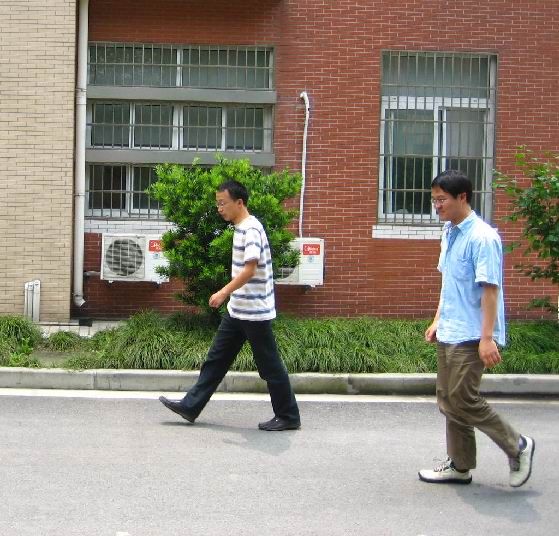

In [4]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [12]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    mask = np.array(mask)
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]
    num_objs = len(obj_ids)
    boxes = []

    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    masks, _ = torch.max(masks, 0)
    masks = torch.unsqueeze(masks, 0)
    #masks = 1-masks

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {} #타겟은 여러가지 정보를 담고있는데
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target

  def __len__(self):
    return len(self.imgs)

In [13]:
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as tfF
import matplotlib.pyplot as plt

def show(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
    img = img.detach()
    img = tfF.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

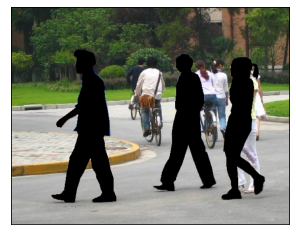

In [14]:
from torchvision.transforms import transforms

dataset = PennFudanDataset('PennFudanPed/')
data_num = 15
tmp_img = torch.moveaxis(torch.tensor(np.array(dataset[data_num][0])), 2, 0)
masks = dataset[data_num][1]['masks'].type(torch.bool) #target의 1번 인덱스의 mask를 가져온다. 그리고 타입을 bool타입으로 바꿨다.

imgs_with_masks = [
  draw_segmentation_masks(tmp_img, masks=masks, alpha=1)
]

show(imgs_with_masks)

In [15]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29552, done.
remote: Counting objects: 100% (2095/2095), done.
remote: Compressing objects: 100% (578/578), done.
remote: Total 29552 (delta 1556), reused 1956 (delta 1478), pack-reused 27457
Receiving objects: 100% (29552/29552), 37.49 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (22172/22172), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [16]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

필로우 이미지를 텐서로 바꿔준다.

In [17]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1) #랜덤시드를 주면 왜 안되는거지?? 
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=1, shuffle=True, num_workers=4,
  collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=4, #데이터셋을 gpu로 올리기 위한 코어 수
  collate_fn=utils.collate_fn
)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(mid_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)

In [19]:
class Up(nn.Module):
  """Upscaling then double conv"""
  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()
    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
    diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

In [20]:
class Down(nn.Module):
  """Downscaling with maxpool then double conv"""
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      nn.MaxPool2d(2),
      DoubleConv(in_channels, out_channels)
    )
  
  def forward(self, x):
    return self.maxpool_conv(x)

In [21]:
class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
  
  def forward(self, x):
    return self.conv(x)

In [22]:
class UNet(nn.Module):
  def __init__(self, n_classes, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = 3
    self.n_classes = n_classes
    self.bilinear = bilinear
    self.inc = DoubleConv(self.n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor, bilinear)
    self.up2 = Up(512, 256 // factor, bilinear)
    self.up3 = Up(256, 128 // factor, bilinear)
    self.up4 = Up(128, 64, bilinear)
    self.outc = OutConv(64, n_classes)
    
  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = UNet(num_classes)
# model = get_detection_model(num_classes)
# move model to the right device

model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss() #원래 로스를 저번에는(패스터 rcnn) 정의하지 않았는데
#그때는 잘 패킹이 되어있는걸 썼기 때문, 근데 이번에는 CEL을 쓰겠다.

optimizer = torch.optim.RMSprop(params, lr=0.001, weight_decay=1e-8, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

In [29]:
# let's train it for 10 epochs
num_epochs = 50

for epoch in range(num_epochs):
  print(f'train, epoch: {epoch}')
  # train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

  for iter, data in enumerate(data_loader, 0):
    rgb = data[0][0].to(device)
    rgb = rgb.unsqueeze(0) # to match batch dimension
    targets = {k: v[0].to(device) for k, v in data[1][0].items()}
    gt_mask = torch.unsqueeze(targets['masks'], 0).long()

    output = model(rgb)
    # output, _ = torch.max(output, dim=1)
    # output = torch.unsqueeze(output, 0)

    optimizer.zero_grad()
    loss = criterion(output, gt_mask) #로스를 뽑는 과정
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    if iter%10 == 0:
      print(f'epoch: {epoch}, iter: {iter}, loss: {loss:.3f}')

    # evaluate on the test dataset
  model.eval()
  print(f'eval, epoch: {epoch}')
  for iter, data in enumerate(data_loader_test, 0):
    rgb = data[0][0].to(device)
    rgb = rgb.unsqueeze(0) # to match batch dimension
    targets = {k: v[0].to(device) for k, v in data[1][0].items()}
    gt_mask = torch.unsqueeze(targets['masks'], 0).long()
    
    with torch.no_grad(): #원래는 trianing 때 백프롭에 변수를 저장하는데, 얘를 쓰면 변수를 저장하지 않고 output만 보기때문에 얘를 쓴다
      output = model(rgb)
      loss = criterion(output, gt_mask)

      if iter%10 == 0:
        print(f'epoch: {epoch}, iter: {iter}, loss: {loss:.3f}')

train, epoch: 0
epoch: 0, iter: 0, loss: 0.176
epoch: 0, iter: 10, loss: 0.421
epoch: 0, iter: 20, loss: 0.369
epoch: 0, iter: 30, loss: 0.240
epoch: 0, iter: 40, loss: 0.393
epoch: 0, iter: 50, loss: 0.532
epoch: 0, iter: 60, loss: 0.255
epoch: 0, iter: 70, loss: 0.349
epoch: 0, iter: 80, loss: 0.501
epoch: 0, iter: 90, loss: 0.296
epoch: 0, iter: 100, loss: 0.453
epoch: 0, iter: 110, loss: 0.514
eval, epoch: 0
epoch: 0, iter: 0, loss: 0.349
epoch: 0, iter: 10, loss: 0.592
epoch: 0, iter: 20, loss: 0.422
epoch: 0, iter: 30, loss: 0.386
epoch: 0, iter: 40, loss: 0.360
train, epoch: 1
epoch: 1, iter: 0, loss: 0.417
epoch: 1, iter: 10, loss: 0.370
epoch: 1, iter: 20, loss: 0.441
epoch: 1, iter: 30, loss: 0.215
epoch: 1, iter: 40, loss: 0.415
epoch: 1, iter: 50, loss: 0.250
epoch: 1, iter: 60, loss: 0.518
epoch: 1, iter: 70, loss: 0.178
epoch: 1, iter: 80, loss: 0.494
epoch: 1, iter: 90, loss: 0.462
epoch: 1, iter: 100, loss: 0.387
epoch: 1, iter: 110, loss: 0.447
eval, epoch: 1
epoch: 1,

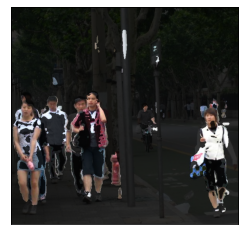

In [31]:
# pick one image from the test set
data_num = 15
img, _ = dataset_test[data_num]

# put the model in evaluation mode
model.eval()

with torch.no_grad():
  prediction = model(torch.unsqueeze(img.to(device),0))

prediction = torch.squeeze(prediction, 0)
prediction, indices = torch.max(prediction, dim=0)
prediction = torch.where(prediction>=0.5, True, False)

imgs_with_masks = [
  draw_segmentation_masks((img*255).type(torch.uint8), masks=prediction, alpha=0.8)
]

show(imgs_with_masks)

In [ ]:
|